Proposed Solution Dylan Houtman

plan van aanpak:
Zoveel mogelijk de focus op taalonafhankelijke features. Features op basis van de eigenschappen in de url en de structuur en content van de HTML pagina. Aangevuld met enkele termafhankelijke features, die duidelijk een bepaalde categorie aanduiden (contact us, about us). 

Categorieen met inschatting eigenschappen:

Homepage - "Korte url, veel verschillende soorten informatie. afbeeldingen"

Landing page - "Veel links naar externe pagina's, afbeeldingen met links"

About Us - "bevat vaak "about" in de url"

Contact Us - "Bevat vaak "contact" in de url. Ook links naar mailadressen en social media"

Product Category & Sub-Category Pages Product Detail Pages (PDP) - "Bevat vaak "product" in de url met productinformatie inclusief een afbeelding of video. Optie tot kopen/add to cart"

Comparison page - Offerings Comparison page - Reviews - "Vergelijking tussen verschillende zaken. Lastig in te schatten welke specifieke eigenschappen hier bij horen. Optie om een van de producten te kopen eventueel"

FAQ Pages - "Bevat vaak FAQ in de url en vraagtekens in de tekst"

Blog Category & Tag Pages - "Veel interne links"

PDFs - "eindigen met .pdf in de url"

Resource guide - "veel informatie over 1 onderwerpen met veel tekst zowel interne als externe links"

Article - Glossary - "Veel links en description list"

Article - List "veel ol/ul elementen"

Article - How-To "bevat vaak how to in de tekst en how-to in url

Article - Tool - "interactief. Veel javascript"

Article - Template / kit - "Template vaak in tekst en download button"

Article - Long-read - "veel tekst"

Blog post - "restgroep voor articles"

Forum - post / q&a - "Forum met vaak veel interne links en optie om te reageren"

Forum - category - "Veel interne links naar blogs"

Social media - Post - "Social media in url en optie om te posten"

Social media - Page - "Social media in url en contactgegevens"

Error pages (404, 401, 410) - "error code in url of titel"

Cookies pop up - "cookie in url en popup in javascript"

Importing packages

In [1]:
import urllib
import json
import os
from bs4 import BeautifulSoup
from pathlib import PurePosixPath
import numpy as np
import pandas as pd

In [2]:
# read and inspect content urls.json  

url_file = open('data/urls.json')
url_data = json.load(url_file)
url_file.close()

pages = [page for page in os.listdir('pages/')]

print(f"url_data bevat {len(url_data)} urls.")
print(f"de folder pages bevat {len([page for page in pages])} files.")


url_data bevat 24240 urls.
de folder pages bevat 11264 files.


In [3]:
# Keep non-missing values

url_pages_encoded = [urllib.parse.quote_plus(url) for url in url_data]
url_html_combinations = list(set(pages).intersection(url_pages_encoded))

print(f"van {len(url_html_combinations)} urls is een corresponderend html bestand gevonden in pages.")


van 11264 urls is een corresponderend html bestand gevonden in pages.


In [4]:
# function to build features

def get_features(html_soup, filename):
    """
    Input: html soup, BeautifulSoup(html_file)
    Output: dictionary with features below (a.o.)
    
    - Url
    - All text
    - Text length
    - Url depth
    - Title similarity with class
    - number of forms
    - social media platform in url
    - number of videos
    - number of images
    - number of unordered lists
    - number of ordered lists
    - number of descriptive lists
    - number of links to mailadresses
    - error numbers in url
    - pdf download link (endswith .pdf)
    - number of filters
    - number of internal links (within same domain)
    - number of external links (outside domain)
    - checks if {term} exists in url/text
    
    """
    output = {}
    
    ### URL related features
    
    # url
    url = urllib.parse.unquote_plus(filename) 
    output["url"] = url
    
    # url length
    output["url_length"] = len(url)
    
    # url path length
    url_parts = PurePosixPath(
                    urllib.parse.unquote(
                        urllib.parse.urlparse(url).path
                    )
                ).parts
    
    # corrigeren voor '\' het eerste element
    url_path_length = len(url_parts)-1
    output["url_path_length"] = url_path_length
    
    # number of digits in url
    output["digit_count_in_url"] = len([digit for digit in url if digit.isdigit()])

    # number of parameters in url
    output["param_count_in_url"] = len(url.split('&'))-1
    
    # number of fragments in url
    output["fragment_count_in_url"] = len(url.split('#'))-1
        
    # number of subdomains in url
    output["subdomain_count_in_url"] = len(url.split('http')[-1].split('//')[-1].split('/'))-1
 
    # social media platform in domain
    social_media_list = ['facebook', 'linkedin', 'instagram', 'twitter', 'youtube', 'tiktok', 'pinterest', 'snapchat']
    social_in_domain = False
    domain = urllib.parse.urlparse(url).hostname    
    for social in social_media_list:
        if social in domain:
            social_in_domain = True
            break
       
    output["social_in_domain"] = social_in_domain

    # check if url ends with .pdf
    pdf_download_url = False
    if url.endswith(".pdf"):
        pdf_download_url = True
        
    output["pdf_download_url"] = pdf_download_url
    

    ### HTML related features
    
    # all text
    try:
        body_text = html_soup.body.get_text(strip=True)
    except:
        body_text = ""
    output["body_text"] = body_text
    
    # text length
    output["body_text_length"] = len(body_text)

    # title
    try:
        title = html_soup.find_all('title')[0].text
    except:
        title = ""
    
    output["title"] = title
        
    # number of forms
    output["form_count"] = len(html_soup.find_all('form'))
    
    # number of scripts
    output["script_count"] = len(html_soup.find_all('script'))
    
    # number of videos
    output["video_count"] = len(html_soup.find_all('video'))
        
    # number of images 
    output["img_count"] = len(html_soup.find_all('img'))
    
    # unordered list count
    output["ul_count"] = len(html_soup.find_all('ul'))
        
    # ordered list count
    output["ol_count"] = len(html_soup.find_all('ol'))
        
    # descriptive list count
    output["dl_count"] = len(html_soup.find_all('dl'))
       
    # number of headers
    headers = ['h{}'.format(i) for i in range(7)]
    header_count = 0
    for header in headers:
        header_count += len(html_soup.find_all(header))
        
    all_links = [link["href"] for link in html_soup.find_all('a', href=True)]
    # number of mail address links
    output["mail_link_count"] = len([link for link in all_links if "mailto:" in link.lower()])
  
    # error number in url
    error_codes = ["400", "401", "402", "403", "404", 
                   "405", "406", "407", "408", "409", 
                   "410", "411", "412", "413", "414", 
                   "415", "416", "417", "418", "421", 
                   "422", "423", "424", "425", "426",
                   "428", "429", "431", "451", 
                   
                   "500", "501", "502", "503", "504", 
                   "505", "506", "507", "508", "509", 
                   "510", "511"]

    error_code_in_title = False
    for error_code in error_codes:
        if error_code in title.lower():
            error_code_in_title = True
            break
    
    output["error_code_in_title"] = error_code_in_title

    #total script length
    scripts = [script.string.strip() for script in html_soup.find_all('script') if script.string != None]

    output["total_script_length"] = len("".join(scripts))
    
    output["script_to_body_ratio"] = output["total_script_length"]/(output["body_text_length"]+1)
     
    # filter button count (based on onclick attribute existing)
    all_buttons = html_soup.find_all('button')
    all_buttons_with_onclick = [button for button in all_buttons if "onclick" in button]
    output["filter_button_count"] = len([button for button in all_buttons_with_onclick if "filter" in button["onclick"].lower()])
    output["download_button_count"] = len([button for button in all_buttons if "download" in button.text.lower()])
    
    # number of internal and external links
    internal_links = []
    external_links = []
    for link in all_links:
        if domain in link:
            internal_links.append(link)
        else:
            external_links.append(link)
            
    unique_internal_link_count = len(list(set(internal_links)))
    unique_external_link_count = len(list(set(external_links)))
        
    output["unique_internal_link_count"] = unique_internal_link_count
    output["unique_external_link_count"] = unique_external_link_count


    ### Term checks (language dependent, only english)
    
    # check if "home" in url
    home_in_url = False
    if "home" in url:
        home_in_url = True
    output["home_in_url"] = home_in_url
    
    # check if "about" in url or title
    about_in_url_or_title = False
    if "about" in url or "about us" in title.lower():
        about_in_url_or_title = True
    output["about_in_url_or_title"] = about_in_url_or_title
    
    # check if "contact" in url or title
    contact_in_url_or_title = False
    if "contact" in url or "contact" in title.lower():
        contact_in_url_or_title = True
    output["contact_in_url_or_title"] = contact_in_url_or_title
        
    # check if "FAQ" in url ro title
    faq_in_url_or_title = False
    if "faq" in url or "faq" in title.lower() or "frequently asked" in title.lower():
        faq_in_url_or_title = True
    output["faq_in_url_or_title"] = faq_in_url_or_title
        
    # check if "how-to" in url or title
    howto_in_url_or_title = False
    if "how-to" in url or "how to" in title.lower():
        howto_in_url_or_title = True
    output["howto_in_url_or_title"] = howto_in_url_or_title
        
    # check if "product" in url or title
    product_in_url_or_title = False
    if "product" in url or "product" in title.lower():
        product_in_url_or_title = True
    output["product_in_url_or_title"] = product_in_url_or_title        
   
    # check if "blog" in url or title
    blog_in_url_or_title = False
    if "blog" in url or "blog" in title.lower():
        blog_in_url_or_title = True
    output["blog_in_url_or_title"] = blog_in_url_or_title        
   
    # check if "review" in url or title
    review_in_url_or_title = False
    if "review" in url or "review" in title.lower():
        review_in_url_or_title = True
    output["review_in_url_or_title"] = review_in_url_or_title        
 
    # check if "tool" in url or title
    tool_in_url_or_title = False
    if "tool" in url or "tool" in title.lower():
        tool_in_url_or_title = True
    output["tool_in_url_or_title"] = tool_in_url_or_title        
   

    return output

    

In [5]:
# Build dataset with urls and matching content
features = {}

for i, filename in enumerate(url_html_combinations):
    with open(f"pages/{filename}", "r") as f:
        html_file = f.read()
        try:
            soup = BeautifulSoup(html_file)
            features[i] = get_features(soup, filename)

        except Exception as error:
            print(error)

        f.close()



In [6]:
features = pd.DataFrame.from_dict(features, orient='index')

De volgende stap is het opzetten van een clustering model. 

- Ongestructureerde dataset
- Unsupervised
- Op zoek naar onderliggende verbanden in data

Gekozen voor K-means vanwege de eenvoud en snelheid, daarnaast is het aantal clusters bekend.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [8]:
features_scaled = features.copy()

In [9]:
features_scaled = features_scaled.drop(["url", "body_text", "title"], axis=1)

scaler = MinMaxScaler()
features_scaled[features_scaled.columns] = scaler.fit_transform(features_scaled[features_scaled.columns])

Elbow method en Silhouette coefficient om te onderzoeken hoeveel clusters er goed onderscheden kunnen worden in de data.

In [10]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

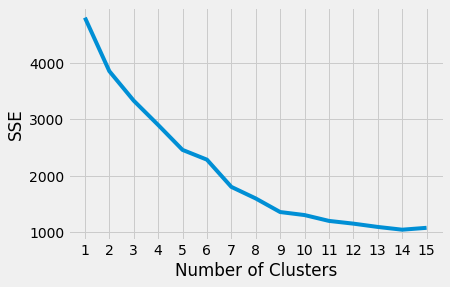

In [11]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 16), sse)
 plt.xticks(range(1, 16))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [17]:

silhouette_coefficients = []

for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features_scaled)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

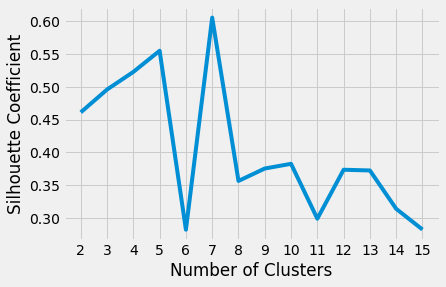

In [18]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 16), silhouette_coefficients)
plt.xticks(range(2, 16))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Onder de huidige omstandigheden lijkt k=8 tot de beste resultaten te leiden. De Elbow zit bij 8/9 en de beste Silhouette score wordt behaald bij k=8

In [12]:
# Join geschatte labels op feature dataframe, om eigenschappen te bekijken.

kmeans = KMeans(n_clusters=8, **kmeans_kwargs)
kmeans.fit(features_scaled)
features["label"] = kmeans.labels_

In [13]:
features.groupby(["label"]).mean()

,url_length,url_path_length,digit_count_in_url,param_count_in_url,fragment_count_in_url,subdomain_count_in_url,social_in_domain,pdf_download_url,body_text_length,form_count,...,unique_external_link_count,home_in_url,about_in_url_or_title,contact_in_url_or_title,faq_in_url_or_title,howto_in_url_or_title,product_in_url_or_title,blog_in_url_or_title,review_in_url_or_title,tool_in_url_or_title
label,,,,,,,,,,,,,,,,,,,,,
0,52.575058,1.525789,1.102771,0.021940,0.000192,1.940916,0.000000,0.000385,9271.145112,1.989800,...,85.840262,0.000000,0.006351,0.003272,0.002887,0.000000,0.000000,0.000000,0.000000,0.018091
1,67.066773,1.931638,2.028617,0.017488,0.000000,2.488076,0.000000,0.014308,1052.620032,0.373609,...,8.963434,0.001590,0.009539,0.000000,0.004769,0.019078,0.112878,0.047695,0.034976,0.004769
2,75.888639,2.769404,3.827897,0.013498,0.000000,3.039370,0.001125,0.003375,5751.552306,2.287964,...,64.371204,0.000000,0.000000,0.002250,0.000000,0.001125,1.000000,0.008999,0.026997,0.003375
3,67.577778,2.038384,2.290909,0.014141,0.000000,2.523232,0.000000,0.000000,12990.963636,2.000000,...,57.379798,0.000000,0.000000,0.000000,0.002020,0.496970,0.000000,0.002020,0.521212,0.012121
4,69.478958,2.424850,1.280561,0.000000,0.000000,2.971944,0.002004,0.000000,12475.180361,1.989980,...,49.020040,0.004008,0.010020,0.000000,0.006012,0.160321,0.000000,1.000000,0.010020,0.052104
5,78.846154,2.793522,4.089069,0.002024,0.000000,3.141700,0.000000,0.000000,6210.803644,1.884615,...,30.506073,1.000000,0.004049,0.000000,0.002024,0.058704,0.139676,0.016194,0.036437,0.002024
6,50.931116,1.608076,3.014252,0.002375,0.000000,2.159145,1.000000,0.000000,1035.021378,0.983373,...,11.926366,0.004751,0.000000,0.000000,0.000000,0.033254,0.002375,0.004751,0.007126,0.004751
7,89.215449,3.705036,6.712609,0.044680,0.000757,3.951534,0.000000,0.044301,6525.849300,1.526316,...,55.331693,0.000000,0.013631,0.001893,0.002272,0.000000,0.000000,0.000000,0.000000,0.004165


In [14]:
features.groupby(["label"]).count()

,url,url_length,url_path_length,digit_count_in_url,param_count_in_url,fragment_count_in_url,subdomain_count_in_url,social_in_domain,pdf_download_url,body_text,...,unique_external_link_count,home_in_url,about_in_url_or_title,contact_in_url_or_title,faq_in_url_or_title,howto_in_url_or_title,product_in_url_or_title,blog_in_url_or_title,review_in_url_or_title,tool_in_url_or_title
label,,,,,,,,,,,,,,,,,,,,,
0,5196,5196,5196,5196,5196,5196,5196,5196,5196,5196,...,5196,5196,5196,5196,5196,5196,5196,5196,5196,5196
1,629,629,629,629,629,629,629,629,629,629,...,629,629,629,629,629,629,629,629,629,629
2,889,889,889,889,889,889,889,889,889,889,...,889,889,889,889,889,889,889,889,889,889
3,495,495,495,495,495,495,495,495,495,495,...,495,495,495,495,495,495,495,495,495,495
4,499,499,499,499,499,499,499,499,499,499,...,499,499,499,499,499,499,499,499,499,499
5,494,494,494,494,494,494,494,494,494,494,...,494,494,494,494,494,494,494,494,494,494
6,421,421,421,421,421,421,421,421,421,421,...,421,421,421,421,421,421,421,421,421,421
7,2641,2641,2641,2641,2641,2641,2641,2641,2641,2641,...,2641,2641,2641,2641,2641,2641,2641,2641,2641,2641


7 van de 8 clusters zijn tussen de 250 en 1000 waarnemingen groot. Cluster 5 is verreweg het grootst met 7823 waarnemingen. Waarschijnlijk veroorzaakt doordat hierin de waarnemingen vallen, die niet eenduidig tot een ander cluster behoren, omdat deze niet bijvoorbeeld een error code geven.

Verklaring clusters:

0 - Blog in url of titel

1 - Product in url of titel

2 - How to in url of titel

3 - Allemaal error code in titel, nauwelijks externe en interne links

4 - Review in url of titel

5 - Restgroep, relatief hoge gemiddelde parameter count

6 - Enorme gemiddelde script to body ratio en social media platform in url. Daarnaast kleinste url_path_length gemiddeld

7 - Home in url. Interessant is dat deze groep de hoogste gemiddelde url_length heeft. Waarschijnlijk omdat home vaak niet de betekenis heeft van homepage.



In [15]:
features["label"] = features["label"].map({
    0: 'blog post',
    1: 'product detail page',
    2: 'article - how-to',
    3: 'error page',
    4: 'comparison page - review',
    5: 'xxx',
    6: 'social media - post or page',
    7: 'homepage',
})

features

,url,url_length,url_path_length,digit_count_in_url,param_count_in_url,fragment_count_in_url,subdomain_count_in_url,social_in_domain,pdf_download_url,body_text,...,home_in_url,about_in_url_or_title,contact_in_url_or_title,faq_in_url_or_title,howto_in_url_or_title,product_in_url_or_title,blog_in_url_or_title,review_in_url_or_title,tool_in_url_or_title,label
0,https://www.amazon.com/Starbucks-Coffee-Colomb...,80,3,7,0,0,3,False,False,,...,False,False,False,False,False,False,False,False,False,homepage
1,https://shop.gardellicoffee.com/sold-out/387-b...,112,2,3,0,0,2,False,False,shopping_cartCart(0)[ Roast Day: 24 Jan 2022...,...,False,False,False,False,False,False,False,False,False,homepage
2,https://www.sterndrive.cc/product/mercruiser_a...,84,2,6,0,0,2,False,False,ACCOUNTCONTACTMY CARTShop By:Free Shipping on ...,...,False,False,False,False,False,True,False,False,True,article - how-to
3,https://www.calnewport.com/books/deep-work/,43,2,0,0,0,3,False,False,Cal NewportCal Newport Website NavigationHomeA...,...,False,False,False,False,False,False,False,False,False,blog post
4,https://ifunny.co/tags/cpap,27,2,0,0,0,2,False,False,,...,False,False,False,False,False,False,False,False,False,blog post
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11259,https://www.skyworksinc.com/-/media/SkyWorks/S...,92,8,3,0,0,8,False,True,,...,False,False,False,False,False,False,False,False,False,homepage
11260,https://exciteforlife.co.uk/product/cbd-gummie...,68,2,3,0,0,3,False,False,Skip to contentINFO@EXCITEFORLIFE.CO.UKMY ACCO...,...,False,False,False,False,False,True,False,False,False,product detail page
11261,http://www.lightingbydesign.biz/,32,0,0,0,0,1,False,False,"(800) 426-33988325-E Patuxent Range Road, Jess...",...,False,False,False,False,False,False,False,False,False,blog post
11262,https://cbdfx.com/why-you-cant-buy-cbd-gummies...,57,1,0,0,0,2,False,False,403 Forbiddennginx,...,False,False,False,False,False,False,False,False,False,product detail page


In [16]:
features[features["label"] == 'xxx']

,url,url_length,url_path_length,digit_count_in_url,param_count_in_url,fragment_count_in_url,subdomain_count_in_url,social_in_domain,pdf_download_url,body_text,...,home_in_url,about_in_url_or_title,contact_in_url_or_title,faq_in_url_or_title,howto_in_url_or_title,product_in_url_or_title,blog_in_url_or_title,review_in_url_or_title,tool_in_url_or_title,label
12,https://athome.starbucks.com/recipe/caramel-ma...,53,2,0,0,0,2,False,False,Find your perfect match.Take our Coffee Quiz. ...,...,True,False,False,False,False,False,False,False,False,xxx
13,https://www.homedepot.com/b/Lighting-Light-Bul...,75,4,4,0,0,4,False,False,Access DeniedYou don't have permission to acce...,...,True,False,False,False,False,False,False,False,False,xxx
14,https://www.sweetsteep.com/homemade-cinnamon-d...,64,1,0,0,0,2,False,False,Skip to contentRECIPESTEA TIPSTEA SHOPSTEA CRA...,...,True,False,False,False,False,False,False,False,False,xxx
21,https://www.homedepot.com/b/Lighting-Chandelie...,61,3,4,0,0,3,False,False,Access DeniedYou don't have permission to acce...,...,True,False,False,False,False,False,False,False,False,xxx
41,https://www.cnet.com/home/security/vivint-home...,63,3,0,0,0,4,False,False,Meat Loaf dies at 74Intel's $100B chip 'megafa...,...,True,False,False,False,False,False,False,True,False,xxx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11180,https://www.ohman.in/home-remedies-for-prematu...,61,1,0,0,0,2,False,False,HomeShopErectile Dysfunction MedicinesPrematur...,...,True,False,False,False,False,False,False,False,False,xxx
11182,https://www.tasteofhome.com/collection/secret-...,78,2,0,0,0,3,False,False,Please enable cookies.Error1020Ray ID: 6d22220...,...,True,False,False,False,False,False,False,False,False,xxx
11184,https://blog.1000bulbs.com/home/light-bulb-sha...,66,2,4,0,0,2,False,False,HomeAbout UsGlossaryLearning CenterHome Lighti...,...,True,False,False,False,False,False,True,False,False,xxx
11227,https://www.homedepot.com/b/Kitchen-Water-Filt...,111,3,3,0,0,3,False,False,Access DeniedYou don't have permission to acce...,...,True,False,False,False,False,False,False,False,False,xxx


In [23]:
def categorize_url(url, path, scaler = scaler, model=kmeans):
    """
    Input url is a parsed url with urllib.parse.quote_plus(url) and corresponding html file (same parsed name)
    Input path is het volledige pad naar het html bestand
    """
    
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
    
    features = {}
    with open(f"{path}", "r") as f:
        html_file = f.read()
        try:
            soup = BeautifulSoup(html_file)
            features[0] = get_features(soup, url)

        except Exception as error:
            print(error)

        f.close()
    
    features = pd.DataFrame.from_dict(features, orient='index')
    
    features_scaled = features.copy()
    features_scaled = features_scaled.drop(["url", "body_text", "title"], axis=1)
    features_scaled[features_scaled.columns] = scaler.transform(features_scaled[features_scaled.columns])
    
    label = model.predict(features_scaled)
    
    return(label)
    

In [24]:

url = "https%3A%2F%2Fblog.easybreathe.com%2Ftry-one-of-the-best-cpap-masks-of-2016-risk-free%2F"
path = "pages/https%3A%2F%2Fblog.easybreathe.com%2Ftry-one-of-the-best-cpap-masks-of-2016-risk-free%2F"

categorize_url(url, path)

array([4], dtype=int32)